# Compute theoretical prediction for xi(r,z=0) from CAMB

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import camb
from camb import model, initialpower

In [3]:
# Cosmology parameters in CoLoRe file (at some point it should read this from CoLoRe files)
h=0.7
Omega_m=0.3
Omega_l=0.7
Omega_b=0.05
w=-1.0
ns=0.96
sigma_8=0.803869
# prepare for CAMB
H0=100.0*h
ombh2=Omega_b*h*h
Omega_c=Omega_m-Omega_b
omch2=Omega_c*h*h

In [4]:
# setup parameters in CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(ns=ns)
default_As=pars.InitPower.ScalarPowerAmp[0]
print('default As=',default_As)
# we need to compute dark matter power to get sigma_8 in default settings
pars.set_matter_power(redshifts=[0.0], kmax=100.0)
default_results = camb.get_results(pars)
default_sigma_8=default_results.get_sigma8()[0]
print('default s8=',default_sigma_8)

default As= 2e-09
default s8= 0.794118429897844


In [5]:
# figure out right A_s to get right sigma_8
new_As=default_As*((sigma_8/default_sigma_8)**2)
pars.InitPower.set_params(As=new_As)
new_results = camb.get_results(pars)
new_sigma_8=new_results.get_sigma8()[0]
print('new As=',new_As)
print('new s8=',new_sigma_8)

new As= 2.0494154566384565e-09
new s8= 0.803869


In [6]:
# return the matter power spectrum at the desired redshift
new_results.calc_power_spectra(pars)
kh, z, pk = new_results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 10000)

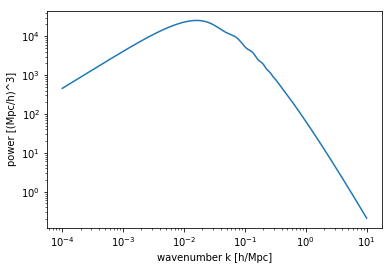

In [7]:
plt.xlabel('wavenumber k [h/Mpc]')
plt.ylabel('power [(Mpc/h)^3]')
plt.loglog(kh,pk[0])

In [8]:
# given an array of P(k), compute integral to get xi(r). It could use a smarter FFT code.
def xi_from_pk(r,ks,Ps,G):
    dlnk=np.log(ks[1])-np.log(ks[0])
    x=ks*r
    fs=(ks**3)*Ps*np.sin(x)/x
    # smooth power at high-k, using Gaussian of width G, to reduce numerical noise
    fs*=np.exp(-(G*ks)**2)
    return np.sum(fs)*(0.5*dlnk/(np.pi**2))  

In [9]:
# will evaluate correlation function at these separations
rs=np.linspace(0.01,200.0,1000)
xis_01=np.zeros(rs.shape)
xis_05=np.zeros(rs.shape)
xis_10=np.zeros(rs.shape)
xis_20=np.zeros(rs.shape)
xis_40=np.zeros(rs.shape)
for i,r in enumerate(rs):
    xis_01[i]=xi_from_pk(r,kh,pk[0],0.1)
    xis_05[i]=xi_from_pk(r,kh,pk[0],0.5)
    xis_10[i]=xi_from_pk(r,kh,pk[0],1.0)
    xis_20[i]=xi_from_pk(r,kh,pk[0],2.0)
    xis_40[i]=xi_from_pk(r,kh,pk[0],4.0)

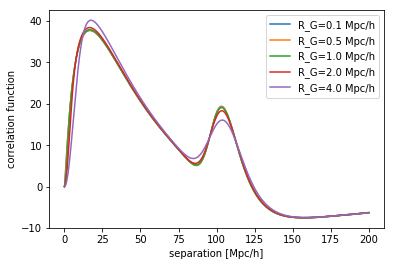

In [10]:
plt.xlabel('separation [Mpc/h]')
plt.ylabel('correlation function')
plt.plot(rs,rs*rs*xis_01,label='R_G=0.1 Mpc/h')
plt.plot(rs,rs*rs*xis_05,label='R_G=0.5 Mpc/h')
plt.plot(rs,rs*rs*xis_10,label='R_G=1.0 Mpc/h')
plt.plot(rs,rs*rs*xis_20,label='R_G=2.0 Mpc/h')
plt.plot(rs,rs*rs*xis_40,label='R_G=4.0 Mpc/h')
plt.legend()

In [11]:
# write correlation to file
f = open('camb_xi_01.txt','w')
for r,xi in zip(rs,xis_01):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()

f = open('camb_xi_05.txt','w')
for r,xi in zip(rs,xis_05):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()

f = open('camb_xi_10.txt','w')
for r,xi in zip(rs,xis_10):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()

f = open('camb_xi_20.txt','w')
for r,xi in zip(rs,xis_20):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()

f = open('camb_xi_40.txt','w')
for r,xi in zip(rs,xis_40):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()

In [45]:
#Now want to generate the xi_l functions to include RSDs, following section 4.5 of Slosar et al 2011.
#First we define the polynomials P_l, k_l and C_l:
import numpy.polynomial.legendre as legendre
def P0(x):
    return legendre.legval(x,[1])
def P2(x):
    return legendre.legval(x,[0,0,1])
def P4(x):
    return legendre.legval(x,[0,0,0,0,1])
def k0(x):
    return (np.sin(x))/x
def k2(x):
    return (np.sin(x)*(x**2 - 3) + np.cos(x) * (3*x))/(x**3)
def k4(x):
    return (np.sin(x)*(x**4 - 45*(x**2) + 105) + np.cos(x) * (10*(x**3) - 105*x))/(x**5)
def C0(x):
    return 1 + (2./3.)*x + (1./5.)*(x**2)
def C2(x):
    return (4./3.)*x + (4./7.)*(x**2)
def C4(x):
    return (8./35.)*(x**2)

In [69]:
#Now calculate the xi_l.
def xi0(r,R):
    return ((4*np.pi)/((2*np.pi)**3)) * np.trapz(np.outer(pk[0],np.ones_like(r))*k0(np.outer(kh,r))*(np.outer(kh,np.ones_like(r))**2)*np.exp(-(R*np.outer(kh,np.ones_like(r)))**2),kh,axis=0)
def xi2(r,R):
    return ((4*np.pi)/((2*np.pi)**3)) * np.trapz(np.outer(pk[0],np.ones_like(r))*k2(np.outer(kh,r))*(np.outer(kh,np.ones_like(r))**2)*np.exp(-(R*np.outer(kh,np.ones_like(r)))**2),kh,axis=0)
def xi4(r,R):
    return ((4*np.pi)/((2*np.pi)**3)) * np.trapz(np.outer(pk[0],np.ones_like(r))*k4(np.outer(kh,r))*(np.outer(kh,np.ones_like(r))**2)*np.exp(-(R*np.outer(kh,np.ones_like(r)))**2),kh,axis=0)

In [95]:
#Now sum them up.
def xi(r,mu,b,beta,R_smooth):
    return (b**2) * (C0(beta)*xi0(r,R_smooth)*P0(mu) + C2(beta)*xi2(r,R_smooth)*P2(mu) + C4(beta)*xi4(r,R_smooth)*P4(mu))

/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/jfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide


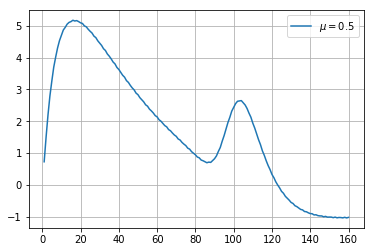

In [110]:
r = np.linspace(0,160,161)
mu_values = [0.5]
b = 1.       #-0.133
D = 0.3698264809652976
beta = 0.    #0.649*0.8
R_smooth = 0.
for mu in mu_values:
    plt.plot(r,(D**2)*(r**2)*xi(r,mu,b,beta,R_smooth),label=r'$\mu={}$'.format(mu))
plt.grid()
plt.legend()
plt.show()